## Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)
Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
2. Повторить п.1, но используя уже не медиану, а max
3. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
4. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
5. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import conda.cli

In [2]:
try:
    import gensim
except ModuleNotFoundError:
    !pip install gensim

try:
    import pymorphy2
except ModuleNotFoundError:
    conda.cli.main('conda', 'install',  '-c', 'conda-forge pymorphy2') 

try:
    import nltk
except ModuleNotFoundError:
    !pip install nltk

try:
    import razdel
except ModuleNotFoundError:
    conda.cli.main('conda', 'install',  '-c', 'conda-forge razdel')
    #conda install -c conda-forge razdel # https://anaconda.org/conda-forge/razdel"""

In [3]:
import pandas as pd
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel
# conda install razdel

import pymorphy2

In [4]:
from nltk.corpus import stopwords

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
# News
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(2)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...


In [8]:
# Users and last read news
users = pd.read_csv("users_articles.csv")
users.head(2)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"


In [9]:
nltk.download('stopwords')
"""LookupError: 
**********************************************************************
  Resource stopwords not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('stopwords')"""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanbovsunovskii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"LookupError: \n**********************************************************************\n  Resource stopwords not found.\n  Please use the NLTK Downloader to obtain the resource:\n\n  >>> import nltk\n  >>> nltk.download('stopwords')"

In [10]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)
morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-12-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 28.4 s, sys: 210 ms, total: 28.6 s
Wall time: 28.7 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 38s, sys: 577 ms, total: 3min 39s
Wall time: 3min 40s


In [15]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [16]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [17]:
common_dictionary[10]

'ватутин'

In [18]:
LdaModel?

In [19]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 57.4 s, sys: 641 ms, total: 58.1 s
Wall time: 37.7 s


In [20]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [21]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.87534004), (6, 0.10066851)]

In [22]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: пациент область турецкий лечение турция офицер совет
topic_1: век активность достигать лёд одежда баланс выяснить
topic_2: китайский китай польша продолжительность белоруссия фильм германия
topic_3: продукция производитель спрос способность рынок кризис дефицит
topic_4: исследование научный университет топливо снизиться дыра сигнал
topic_5: закон рак законопроект уголовный госдума преступление поправка
topic_6: россия сша nn американский банк система ракета
topic_7: выяснить террорист уничтожить боевик культурный чечня житель
topic_8: военный наука журнал первый помощь россия российский
topic_9: обнаружить тело произойти район армия пострадать данные
topic_10: население погибнуть километр граница режим эффективность около
topic_11: доллар квартира высота следствие метод берег видео
topic_12: температура градус компьютер рт стресс горный сахар
topic_13: украина российский nn проект новый решение вопрос
topic_14: британский налог солнце подчёркивать великобритания остров восточн

In [23]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [24]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.167370,0.000000,0.011286,0.0,0.0,0.000000,0.743286,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.049338,0.021333,0.000000
1,4896,0.000000,0.287141,0.000000,0.0,0.0,0.046979,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.530364,0.000000,0.0,0.113384,0.000000,0.000000
2,4897,0.000000,0.839949,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.097562,0.0,0.000000,0.000000,0.039539
3,4898,0.000000,0.124364,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.864085,0.000000,0.0,0.000000,0.000000,0.000000
4,4899,0.844324,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.128602,0.0,0.000000,0.000000,0.000000


In [25]:
users.head(2)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"


In [26]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

### 1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
### 2. Повторить п.1, но используя уже не медиану, а max

In [76]:
def get_user_embedding(user_articles_list, using_function = 'mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if using_function == 'max':
        user_vector = np.max(user_vector, 0)
    elif using_function == 'median':
        user_vector = np.median(user_vector, 0)
    elif using_function == 'mean':
        user_vector = np.mean(user_vector, 0)
    else:
        user_vector = np.mean(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [77]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'max'), 1)])
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'median'), 1)])

user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [78]:
target = pd.read_csv("users_churn.csv")
#target.head(2)

In [79]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_median = pd.merge(user_embeddings_median, target, 'left')

In [80]:
#разделим данные на train/test
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=11)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=11)
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=11)

## Обучаем по очереди на max, mean, median

In [81]:
X_train, X_test, y_train, y_test = X_train_max, X_test_max, y_train_max, y_test_max
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22261609, 0.2475795 , 0.08432824, 0.75440544, 0.06514557,
       0.51551754, 0.07398104, 0.09051015, 0.02627243, 0.00176139])

### Рассчитаем Precision, Recall, F_score

In [82]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.327017, F-Score=0.793, Precision=0.752, Recall=0.838


Confusion matrix, without normalization
[[1709   63]
 [  38  190]]


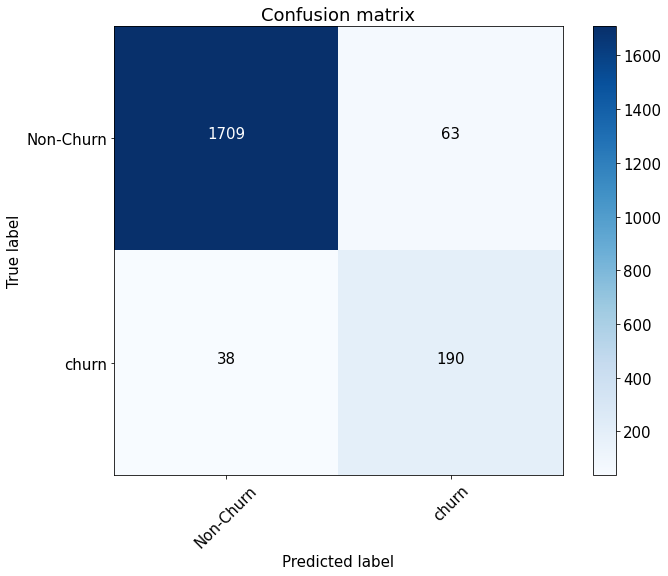

In [83]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [84]:
roc_auc_val = roc_auc_score(y_test, preds)
print(roc_auc_val)

0.9749663379668132


In [85]:
max_quality_charact = [fscore[ix], precision[ix], recall[ix], roc_auc_val]

### Обучаем на mean

In [86]:
X_train, X_test, y_train, y_test = X_train_mean, X_test_mean, y_train_mean, y_test_mean
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.38772824, 0.36559857, 0.28451325, 0.46826961, 0.10785117,
       0.19356746, 0.15350539, 0.05277535, 0.0612047 , 0.02575944])

### Рассчитаем Precision, Recall, F_score

In [87]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.203408, F-Score=0.563, Precision=0.444, Recall=0.768


Confusion matrix, without normalization
[[1553  219]
 [  54  174]]


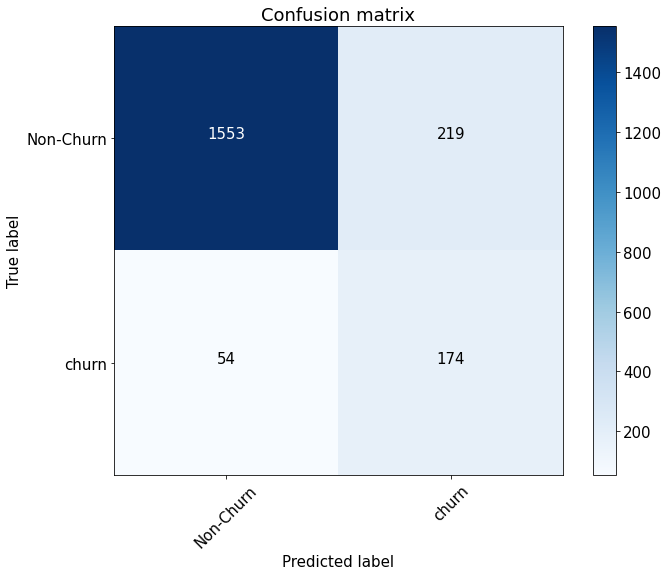

In [88]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [89]:
roc_auc_val = roc_auc_score(y_test, preds)
print(roc_auc_val)

0.9137633163043049


In [90]:
mean_quality_charact = [fscore[ix], precision[ix], recall[ix], roc_auc_val]

### Обучаем на median

In [91]:
X_train, X_test, y_train, y_test = X_train_median, X_test_median, y_train_median, y_test_median
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.21067501, 0.30138776, 0.13777581, 0.42269713, 0.11334247,
       0.14930906, 0.17692638, 0.06796178, 0.05485172, 0.00790656])

### Рассчитаем Precision, Recall, F_score

In [92]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.262541, F-Score=0.681, Precision=0.661, Recall=0.702


Confusion matrix, without normalization
[[1690   82]
 [  69  159]]


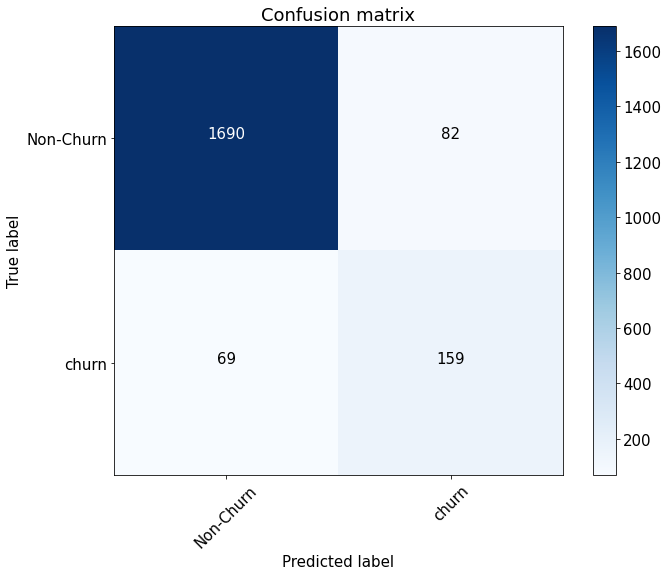

In [93]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [94]:
roc_auc_val = roc_auc_score(y_test, preds)
print(roc_auc_val)

0.9497767415151877


In [95]:
median_quality_charact = [fscore[ix], precision[ix], recall[ix], roc_auc_val]

### Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [96]:
data = np.array((max_quality_charact, mean_quality_charact, median_quality_charact))

In [97]:
data

array([[0.79253112, 0.7519685 , 0.8377193 , 0.97496634],
       [0.56270096, 0.44416244, 0.76754386, 0.91376332],
       [0.68085106, 0.66115702, 0.70175439, 0.94977674]])

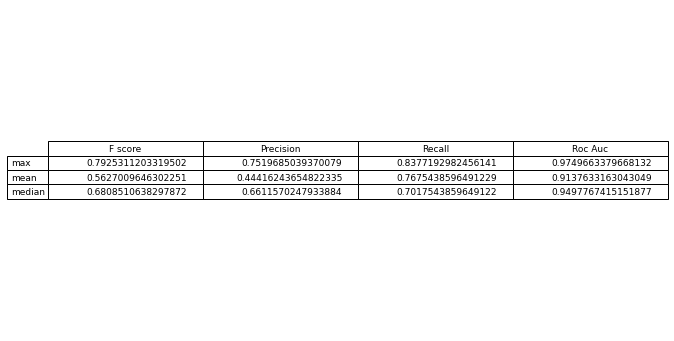

In [98]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10, 5]

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
columns = ['F score', 'Precision', 'Recall', 'Roc Auc']
rows = ['max', 'mean', 'median']
df = pd.DataFrame(data, columns=columns)

ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center', fontsize=20)

fig.tight_layout()

plt.show()

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### Дополнительно, библиотеки для анализа текста
1. spacy 
2. natasha
3. nltk